### P5: Vehicle Detection 
#### This is a pipeline of how algorithm would flow.

In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
import glob
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label



print('Regular required imports.')

Regular required imports.


In [2]:
def color_hist(img,plot_hist=False,ranges=(0,256)):
    # making a hist of 3 channels of image (any colorspace)
    hist1 = np.histogram(img[:,:,0], bins = 32, range=ranges)
    hist2 = np.histogram(img[:,:,1], bins = 32, range=ranges)
    hist3 = np.histogram(img[:,:,2], bins = 32, range=ranges)
    # calculating the number of bin centers
    bin_edges = hist1[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:(len(bin_edges)-1)])/2
    
    # Plotting histograms only when asked for
    if plot_hist is True:
        fig = plt.figure(fig_size = (12,3))
        plt.subplot(131)
        plt.bar(bin_centers,hist1[0])
        plt.xlim(0,256)
        plt.title(' Histogram of 1st channel')
        plt.subplot(132)
        plt.bar(bin_centers,hist2[0])
        plt.xlim(0,256)
        plt.title(' Histogram of 2nd channel')
        plt.subplot(133)
        plt.bar(bin_centers,hist3[0])
        plt.xlim(0,256)
        plt.title(' Histogram of 3rd channel')
    
    hist_features = np.concatenate((hist1[0],hist2[0],hist3[0]))
    #hist_features = hist_features.ravel()
    return hist_features

    
    
    

print('Color Histogram feature extracted.')
    
    

Color Histogram feature extracted.


In [3]:
def color_space_explore(img):
    def plot3d(pixels, color_rgb, axis_labels=list("RGB"),axis_limits = ((0,255),(0,255),(0,255))):
        
        # Plotting color space in 3d
        fig = plt.figure()
        ax = Axes3D(fig)
        
        # Axis limits
        ax.set_xlim(axis_limits[0])
        ax.set_ylim(axis_limits[1])
        ax.set_zlim(axis_limits[2])
        
         # Set axis labels and sizes
        ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
        ax.set_xlabel(axis_labels[0],fontsize=16, labelpad=16)
        ax.set_ylabel(axis_labels[1],fontsize=16, labelpad=16)
        ax.set_zlabel(axis_labels[2],fontsize=16, labelpad=16)
        
        # Scatter Plot
        ax.scatter(pixels[:,:,0].ravel(),
                   pixels[:,:,1].ravel(),
                   pixels[:,:,2].ravel(),
                   c=color_rgb.reshape((-1, 3)), 
                   edgecolors='none')
        return ax
    
    #subsampling
    scale = max(img.shape[0], img.shape[1], 64) / 64 
    img_small = cv2.resize(img,(np.int(img.shape[1]/scale),np.int(img.shape[0]/scale)),interpolation=cv2.INTER_NEAREST)
    img_small_rgb = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2YCrCb)
    img_small_RGB = img_small_rgb / 255
    
    # Plotting
    plot3d(img_small_rgb, img_small_RGB)
    plt.show()
    
    plot3d(img_small_HSV,img_small_RGB, axis_labels=list("YCrCb"))
    plt.show()
    

print("Function for visualization of apt color space.")

Function for visualization of apt color space.


In [4]:
# To reduce size for better computation
def spatial_binning(img,reshape_size=(32,32)):
    img = cv2.resize(img,reshape_size)
    feature_vector = img.ravel()
    return feature_vector
print('Spatial Reduction of images done.')


Spatial Reduction of images done.


In [5]:
from skimage.feature import hog
def hog_vec(img,orient,pixel_per_cell,cell_per_block,visualise=False):
    hog_features,hog_image = hog(img,orientations = orient, 
                                 pixels_per_cell = (pixel_per_cell,pixel_per_cell), 
                                 cells_per_block=(cell_per_block,cell_per_block),
                                 visualise = True,feature_vector=True,block_norm="L2-Hys")
    
    if visualise is True:
        fig = plt.figure(fig_size=(16,16))
        plt.subplot(121)
        plt.imshow(img,cmap='gray')
        plt.title('Original Image')
        plt.subplot(122)
        plt.imshow(hog_image,cmap='gray')
        plt.title('HOG Visualisation')
        
    return hog_features
print('HOG feature vector extracted.')

HOG feature vector extracted.


In [6]:
def comb_feat_vec(img=None,imgs=None, orient=8,pixel_per_cell=8,cell_per_block=2, cspace='RGB'):
    # Initialising a feature list
    features=[]
    if img is None:
        # iterating over all the images and extracting the features and appending in the list
        for file in imgs:
            file_features =[]
            img = mpimg.imread(file) # PNG file format (0-1)

            if cspace != 'RGB':
                if cspace == 'HSV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
                elif cspace == 'LUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
                elif cspace == 'HLS':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
                elif cspace == 'YUV':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
                elif cspace == 'YCrCb':
                    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            else: 
                feature_image = np.copy(img)
            #Extracting the features after size reduction
            spatial_features = spatial_binning(feature_image,reshape_size=(32,32))
            ## Normalizing the feature
            spatial_features = (spatial_features-np.mean(spatial_features))/np.std(spatial_features)
            file_features.append(spatial_features)
            #Extracting the features from color histogram
            color_histogram = color_hist(feature_image,plot_hist=False,ranges=(0,256))
            ## Normalizing the feature
            color_histogram = (color_histogram-np.mean(color_histogram))/np.std(color_histogram)
            file_features.append(color_histogram)
            # Extracting HOG features
            hog_features = hog_vec(feature_image,orient,pixel_per_cell,cell_per_block,visualise=False)
            ## Normalizing the feature
            #hog_features = (hog_features-np.mean(hog_features))/np.std(hog_features)
            # Appending all the features in each iteration
            file_features.append(hog_features)
            features.append(np.concatenate(file_features))
    else:
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
        #Extracting the features after size reduction
        spatial_features = spatial_binning(feature_image,reshape_size=(32,32))
        ## Normalizing the feature
        spatial_features = (spatial_features-np.mean(spatial_features))/np.std(spatial_features)
        features.append(spatial_features)
        #Extracting the features from color histogram
        color_histogram = color_hist(feature_image,plot_hist=False,ranges=(0,256))
        ## Normalizing the feature
        color_histogram = (color_histogram-np.mean(color_histogram))/np.std(color_histogram)
        features.append(color_histogram)
        # Extracting HOG features
        hog_features = hog_vec(feature_image,orient,pixel_per_cell,cell_per_block,visualise=False)
        ## Normalizing the feature
        #hog_features = (hog_features-np.mean(hog_features))/np.std(hog_features)
        # Appending all the features in each iteration
        features.append(hog_features)
        features = np.concatenate(features)
        
        
    return features
        
print('Combined all the features.')
    
######################### MAKE a DT classifier Prunning to merge only good features of these 3 #########################################
    

Combined all the features.


In [7]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=8, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(img)      

        if spatial_feat == True:
            spatial_features = spatial_binning(feature_image,reshape_size=(32,32))
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image,plot_hist=False,ranges=(0,256))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.extend(hog_vec(feature_image[:,:,channel], 
                                    orient,pixel_per_cell,cell_per_block,visualise=False))    
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = hog_vec(feature_image[:,:,hog_channel],orient,pixel_per_cell,cell_per_block,visualise=False)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [8]:
def single_img_features(img, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=8, 
                        pixel_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = spatial_binning(feature_image,reshape_size=(32,32))
        spatial_features = (spatial_features-np.mean(spatial_features))/np.std(spatial_features)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        color_histogram = color_hist(feature_image,plot_hist=False,ranges=(0,256))
        color_histogram = (color_histogram-np.mean(color_histogram))/np.std(color_histogram)
        #6) Append features to list
        img_features.append(color_histogram)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(hog_vec(feature_image[:,:,channel], 
                                    orient,pixel_per_cell,cell_per_block,visualise=False))      
        else:
            hog_features = hog_vec(feature_image[:,:,hog_channel],orient,pixel_per_cell,cell_per_block,visualise=False)
        #8) Append features to list
        img_features.append(hog_features)
        
        #print(np.concatenate(img_features).shape)

    #9) Return concatenated array of features
    return np.concatenate(img_features)
print('Image feature extracter')

Image feature extracter


In [9]:
def draw_box(img,bboxes,color=(0, 0, 255), thick=6):
    # creating a copy
    image = np.copy(img)
    # loopoing over all the vertices in bboxes
    for bbox in bboxes:
        # creating a rectangle
        cv2.rectangle(image,bbox[0],bbox[1],color,thick)
    return image
print('Rectange drawn.')
    
    

Rectange drawn.


In [10]:
import math
def slide_win(img,xy_windows=(64, 64), xy_overlap=(0.75, 0.75)):
    # sliding windows only in the lower half of the image
    x_start = 0
    x_stop = img.shape[1]
    y_start = img.shape[0]/2
    y_stop = 660
    # calculating the total span where window will slide
    x_span = x_stop - x_start
    y_span = y_stop - y_start
    # calculating the number of windows in x-y directions
    nxwindows = 1 + ((x_span - xy_windows[0])/(xy_windows[0]*(1-xy_overlap[0])))
    nywindows = 1 + ((y_span - xy_windows[1])/(xy_windows[1]*(1-xy_overlap[1])))
    
    #Initialising the window list
    window_list = []
    for ny in range(np.int(nywindows)):
        for nx in range(np.int(nxwindows)):
            startx = round(np.int(nx*(np.int((1-xy_overlap[0])*xy_windows[0])) + x_start))
            starty = round(np.int(ny*(np.int((1-xy_overlap[1])*xy_windows[1])) + y_start))
            endx   = round(np.int(startx + xy_windows[0]))
            endy   = round(np.int(starty + xy_windows[1]))
            
            
            window_list.append(((startx,starty),(endx,endy)))
    
    return window_list

print('Window will slide in the lower half of the image fed.')
    
    

Window will slide in the lower half of the image fed.


In [11]:
def search_windows(img,windows,clf,x_scaler, orient,pixel_per_cell,cell_per_block, cspace='HSV'):
    
    on_window = []
    for window in windows:
        # Taking a portion of image and scaling it to 64x64
        test_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        
        # Exctracting features from the test image
        features = single_img_features(test_img, color_space=cspace, 
                                       orient=orient, pixel_per_cell=pixel_per_cell, 
                                       cell_per_block=cell_per_block)
                            
        #features = comb_feat_vec(test_img,windows, orient,pixel_per_cell,cell_per_block, cspace='RGB')
        
        # Trasnforming and reshaping into a column vector
        test_features = x_scaler.transform(np.array(features).reshape(1,-1))
        
        
        # Predict through thee established classifier
        predictions = clf.predict(test_features)
        
        if predictions == 1:
            on_window.append(window)
    return on_window
print('Searching for cars.')

Searching for cars.


In [12]:
#heat_map = np.zeros_like(image[:,:,0]).astype(np.float) ########### To be shifted to main ###########
def heat_map(heat_mapa,box_list):
    for box in box_list:
        heat_mapa[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heat_mapa
print('Heat map created')

Heat map created


In [13]:
def heat_threshold(heat_map,threshold,disp = False):
    heat_map[heat_map<=threshold] = 0
    if disp is True:
        plt.imshow(heat_map)
    return heat_map
print('False Positives removed')

False Positives removed


In [14]:
def heat_box(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img
print('Box on most hot pixels')

Box on most hot pixels


In [15]:
def data_exlore(car_list,noncar_list,disp= False):
    # Initialising the data dictionary
    data={}
    data['cars'] = len(car_list)
    data['non_cars'] = len(noncar_list)
    car_img = mpimg.imread(car_list[np.random.randint(0,len(car_list))])
    noncar_img = mpimg.imread(noncar_list[np.random.randint(0,len(noncar_list))])
    if disp is True:
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(car_img)
        plt.title('Car')
        plt.subplot(122)
        plt.imshow(noncar_img)
        plt.title('Not a car')
    data['image_shape'] = car_img.shape
    return data

print('Data Exploration')

Data Exploration


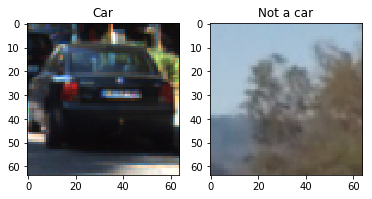

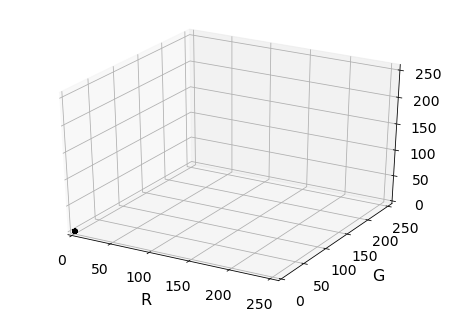

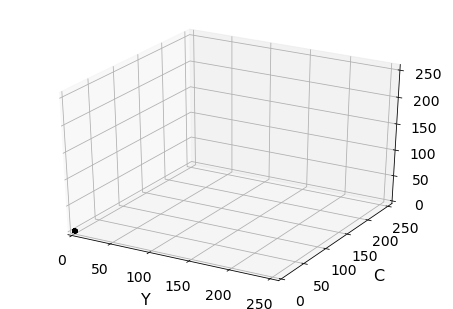

8792 Number of cars
8968 Number of non-cars
(64, 64, 3) Image shape


In [16]:
#################################### Preparation of data for training ###################################
far_cars = glob.glob('../Vehicle_detection/vehicles/vehicles/GTI_Far/image*.png') # Images are in .png file format
left_cars = glob.glob('../Vehicle_detection/vehicles/vehicles/GTI_Left/image*.png')
middle_cars = glob.glob('../Vehicle_detection/vehicles/vehicles/GTI_MiddleClose/image*.png')
right_cars = glob.glob('../Vehicle_detection/vehicles/vehicles/GTI_Right/image*.png')
Kitti_cars = glob.glob('../Vehicle_detection/vehicles/vehicles/KITTI_extracted/*.png')
car_list= (far_cars+left_cars+middle_cars+right_cars+Kitti_cars)
#print(len(car_list))

noncars1 = glob.glob('../Vehicle_detection/non_vehicles/non_vehicles/GTI/image*.png')
noncars2 = glob.glob('../Vehicle_detection/non_vehicles/non_vehicles/Extras/extra*.png')
noncar_list = noncars1 + noncars2
#print(len(noncar_list))

training_set = data_exlore(car_list,noncar_list,disp=True)

color_space_explore(mpimg.imread(car_list[10]))
print(training_set['cars'],'Number of cars')
print(training_set['non_cars'],'Number of non-cars')
print(training_set['image_shape'],'Image shape')

In [17]:
############# Extracting features and apt preprocessing
'''car_features = comb_feat_vec(img=None,imgs=car_list, orient=8,pixel_per_cell=8,cell_per_block=2, cspace='RGB')
noncar_features = comb_feat_vec(img=None,imgs=noncar_list[:len(car_list)], orient=8,pixel_per_cell=8,cell_per_block=2, cspace='RGB')
print('Training data')'''
car_features, noncar_features = [],[]
for file in car_list:
    # Read in each one by on
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    car_feature = single_img_features(image, color_space='YCrCb', 
                                      orient=9, pixel_per_cell=16,
                                      cell_per_block=1)
    car_features.append(car_feature)
for files in noncar_list:
    
    # Read in each one by one
    image = cv2.imread(files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    noncar_feature =single_img_features(image, color_space='YCrCb', 
                                        orient=9, pixel_per_cell=16,
                                        cell_per_block=1)
    noncar_features.append(noncar_feature)


print(len(car_features))

print('Combined feature vector created')

8792
Combined feature vector created


In [18]:
# X,Y for splitting and normalization
print(len(car_features))
print(len(car_features[3]))
print(len(noncar_features[0]))
print(len(noncar_features))
X = np.vstack((car_features, noncar_features)).astype(np.float64)
Y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))
print(X.shape)
print(Y.shape)
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=rand_state)
print("X and y created and split")

8792
3312
3312
8968
(17760, 3312)
(17760,)
X and y created and split


In [19]:
## Normalizing the training/testing data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
print(X_train.shape)
print(y_train.shape)
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)


print('Data Normalized')

(14208, 3312)
(14208,)
Data Normalized


In [20]:
## Making the classifier
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn import grid_search
from sklearn.metrics import accuracy_score
import time
# Going with Linear SVM
parameters = { 'C':[0.001, 0.01, 0.1]}
svr = LinearSVC()
#svr = svm.SVC(kernel = 'rbf')
clf = grid_search.GridSearchCV(svr, parameters)
# Training the classifier
t1 = time.time()
clf.fit(X_train,y_train)
clf.best_params_
t2 = time.time()
print(round(t2-t1, 2), 'Seconds to train SVC...')
print('Accuracy of this classifier is',round(clf.score(X_test,y_test),4))



/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


108.39 Seconds to train SVC...
Accuracy of this classifier is 0.9868


In [2]:
from scipy.ndimage.measurements import label
test_img = glob.glob('../Vehicle_detection/test_images/test*.jpg')
# Threshold for heat_maps
threshold = 2
xy_windows=(64, 64)
xy_overlap=(0.75, 0.75)
orient = 9
pixel_per_cell = 16
cell_per_block = 1
imgs, heat_imgs, window_imgs=[], [],[]
for image in test_img:
    img = cv2.imread(image) # Files are in jpg format (0-255)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    heat_maps = np.zeros_like(img[:,:,0]).astype(np.float)
    #plt.imshow(img)
    #print(img.shape)
    img_copy = np.copy(img)
    #Converting images to (0-1) same as png in training set
    #img = img/255 # Report this error
    #img=img.astype(np.uint8)
    windows = slide_win(img,xy_windows=(64, 64), xy_overlap=xy_overlap)
    hot_windows = search_windows(img,windows,clf,X_scaler, orient,pixel_per_cell,cell_per_block, cspace='YCrCb')
    window_img = draw_box(img, hot_windows, color=(0, 0, 255), thick=6) 
    heat = heat_map(heat_maps,hot_windows)
    heat_thresh = heat_threshold(heat,threshold)
    labels = label(heat_thresh)
    heat_box_img = heat_box(img_copy,labels)
    
    
    fig = plt.figure(figsize=(32,32))
    plt.subplot(321)
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(322)
    plt.imshow(window_img)
    plt.title('Boxes identified')
    plt.subplot(323)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(324)
    plt.imshow(heat_thresh)
    plt.title('After Treshold')
    plt.subplot(325)
    plt.imshow(labels[0])
    plt.title('Number of cars')
    plt.subplot(326)
    plt.imshow(heat_box_img)
    plt.title('Car Positions')
    
    plt.show()


print('Image pipline created') 

NameError: name 'glob' is not defined

In [1]:
def process_image(image):
    #img = image/np.max(image)
    img = image
    img_copy = np.copy(img)
    heat_maps = np.zeros_like(img[:,:,0]).astype(np.float)
    windows = slide_win(img,xy_windows=(64, 64), xy_overlap=(0.75, 0.75))
    hot_windows = search_windows(img,windows,clf,X_scaler, orient=9,pixel_per_cell = 16,cell_per_block = 1, cspace='YCrCb')
    window_img = draw_box(img, hot_windows, color=(0, 0, 255), thick=6) 
    heat = heat_map(heat_maps,hot_windows)
    heat_thresh = heat_threshold(heat,threshold=2)
    labels = label(heat_thresh)
    heat_box_img = heat_box(img_copy,labels)
    return heat_box_img


print('Pipeline created')

Pipeline created


In [27]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import reduce

output_video = '../Vehicle_detection/test_videos_output/test_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../Vehicle_detection/test_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video ../Vehicle_detection/test_videos_output/test_video_out.mp4
[MoviePy] Writing video ../Vehicle_detection/test_videos_output/test_video_out.mp4


 97%|█████████▋| 38/39 [06:03<00:09,  9.54s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../Vehicle_detection/test_videos_output/test_video_out.mp4 

CPU times: user 6min 3s, sys: 156 ms, total: 6min 3s
Wall time: 6min 4s


In [28]:
class HeatHistory():
    def __init__(self):
        self.history = []

def processVideo(inputVideo, outputVideo, frames_to_remember=3, threshhold=1):
    """
    Process the video `inputVideo` to find the cars and saves the video to `outputVideo`.
    """
    history = HeatHistory()

    def pipeline(img):
        boxes = findBoxes(img, svc, scaler, params)
        img_shape = img.shape
        heatmap = add_heat(np.zeros(img_shape), boxes)
        if len(history.history) >= frames_to_remember:
            history.history = history.history[1:]

        history.history.append(heatmap)
        heat_history = reduce(lambda h, acc: h + acc, history.history)/frames_to_remember
        heatmap = apply_threshold(heat_history, threshhold)
        labels = label(heatmap)

        return draw_labeled_bboxes(np.copy(img), labels)

    myclip = VideoFileClip(inputVideo)
    output_video = myclip.fl_image(pipeline)
    output_video.write_videofile(outputVideo, audio=False)
    
processVideo('./videos/project_video.mp4', './video_output/project_video.mp4', threshhold=2)

OSError: MoviePy error: the file ./videos/project_video.mp4 could not be found !
Please check that you entered the correct path.

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from functools import reduce

output_video = '../Vehicle_detection/test_videos_output/project_video_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("../Vehicle_detection/project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video ../Vehicle_detection/test_videos_output/project_video_out.mp4
[MoviePy] Writing video ../Vehicle_detection/test_videos_output/project_video_out.mp4


 99%|█████████▊| 1244/1261 [3:18:55<02:43,  9.59s/it] 